In [1]:
import jittor as jt
import numpy as np
import matplotlib.pyplot as plt
from model import StyledGenerator, Discriminator
from dataset import SymbolDataset

jt.flags.use_cuda = True
jt.flags.log_silent = True

[SYNC][i 0109 10:09:52.675872 76 compiler.py:847] Jittor(1.2.2.13) src: /home/user3/.local/lib/python3.7/site-packages/jittor
[SYNC][i 0109 10:09:52.678530 76 compiler.py:848] cache_path: /home/user3/.cache/jittor/default/g++
[SYNC][i 0109 10:09:52.691904 76 __init__.py:250] Found /usr/local/cuda/bin/nvcc(10.2.89) at /usr/local/cuda/bin/nvcc.
[SYNC][i 0109 10:09:52.769028 76 __init__.py:250] Found gdb(8.1.0) at /usr/bin/gdb.
[SYNC][i 0109 10:09:52.784916 76 __init__.py:250] Found addr2line(2.30) at /usr/bin/addr2line.
[SYNC][i 0109 10:09:52.832578 76 compiler.py:897] pybind_include: -I/usr/include/python3.7m -I/usr/local/lib/python3.7/dist-packages/pybind11/include


[i 0109 10:09:52.658133 56 __init__.py:250] Found g++(7.5.0) at /usr/bin/g++.


[SYNC][i 0109 10:09:52.859500 76 compiler.py:899] extension_suffix: .cpython-37m-x86_64-linux-gnu.so
[SYNC][i 0109 10:09:53.062727 76 __init__.py:169] Total mem: 62.79GB, using 16 procs for compiling.
[SYNC][i 0109 10:09:53.221562 76 jit_compiler.cc:21] Load cc_path: /usr/bin/g++
[SYNC][i 0109 10:09:53.366138 76 init.cc:52] Found cuda archs: [75,]
[SYNC][i 0109 10:09:53.544051 76 __init__.py:250] Found mpicc(2.1.1) at /usr/bin/mpicc.
[SYNC][i 0109 10:09:53.597702 76 compiler.py:654] handle pyjt_include/home/user3/.local/lib/python3.7/site-packages/jittor/extern/mpi/inc/mpi_warper.h
[SYNC][i 0109 10:09:53.645015 76 compile_extern.py:275] Downloading nccl...
[SYNC][i 0109 10:09:53.721052 76 compile_extern.py:16] found /usr/local/cuda/include/cublas.h
[SYNC][i 0109 10:09:53.723612 76 compile_extern.py:16] found /usr/lib/x86_64-linux-gnu/libcublas.so
[SYNC][i 0109 10:09:54.023100 76 compile_extern.py:16] found /usr/local/cuda/include/cudnn.h
[SYNC][i 0109 10:09:54.025500 76 compile_extern.

### Test Discriminator

In [2]:
netD = Discriminator()
nsteps = 6
alpha = 0
batch_size = 16
for step in range(nsteps):
    image_size = 2**(step+2)
    print('Testing image of [%02d x %02d]' % (image_size, image_size))
    image = jt.rand(batch_size, 3, image_size, image_size)
    pred = netD(image, step, alpha)
    assert(pred.shape == [batch_size, 1])

Testing image of [04 x 04]
Testing image of [08 x 08]
Testing image of [16 x 16]
Testing image of [32 x 32]
Testing image of [64 x 64]
Testing image of [128 x 128]


### Test Generator

In [3]:
netG = StyledGenerator()
nsteps = 6
alpha = 0
batch_size = 16
code_dim = 512
z = jt.randn(batch_size, code_dim)

for step in range(nsteps):
    image_size = 2**(step+2)
    print('Testing image of [%02d x %02d]' % (image_size, image_size))
    fake_image = netG(z, step=step, alpha=alpha, style_weight=0.5)
    assert(fake_image.shape == [batch_size, 3, image_size, image_size])

Testing image of [04 x 04]
Testing image of [08 x 08]
Testing image of [16 x 16]
Testing image of [32 x 32]
Testing image of [64 x 64]
Testing image of [128 x 128]


### Test Dataset

In [8]:
import jittor.transform as transform

transform = transform.Compose([
    transform.ToPILImage(),
    transform.RandomHorizontalFlip(),
    transform.ToTensor(),
    transform.ImageNormalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

batch_size = 32
root_path = 'color_symbol_7k'
root_path = 'FFHQ'
train_loader = SymbolDataset(root_path, transform, 32).set_attrs(batch_size=batch_size, shuffle=True)

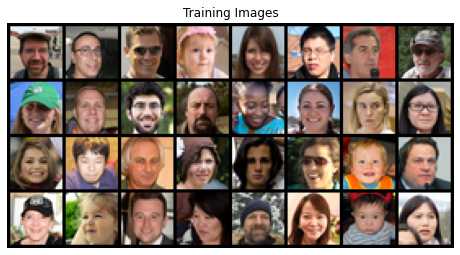

In [9]:
import torchvision.utils
import torch

real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(torch.from_numpy(real_batch.numpy()), padding=2, normalize=True),(1,2,0)))

## Training

In [10]:
import math
import random

### Preset hyper-parameters

In [11]:
init_size = 8
max_size  = 64
init_step = int(math.log2(init_size) - 2)
max_step  = int(math.log2(max_size) - 2)
nsteps = max_step - init_step + 1

lr = 1e-3
mixing = True

code_size = 512
batch_size = {8: 256, 16: 128, 32: 64, 64: 32}
batch_default = 32
gen_sample = {512: (8, 4), 1024: (4, 2)}

phase = 1000
max_iter = 100

### Actual Training

In [12]:
init_size = 8
code_size = 512
batch_size = 64
step = int(math.log2(init_size)) - 2
resolution = 4 * 2 ** step
train_loader = SymbolDataset(root_path, transform, resolution).set_attrs(batch_size=batch_size, shuffle=True)

disc_loss_val = 0
gen_loss_val = 0
grad_loss_val = 0

lr = 1e-3
alpha = 0
used_sample = 0
num_epoch = 100
mixing = True
phase = len(train_loader) * num_epoch // 2

d_optimizer = jt.optim.Adam(netD.parameters(), lr=lr, betas=(0.0, 0.99))
g_optimizer = jt.optim.Adam(
        netG.generator.parameters(), lr=lr, betas=(0.0, 0.99)
    )
g_optimizer.add_param_group(
    {
        'params': netG.style.parameters(),
        'lr': lr * 0.01,
        'mult': 0.01,
    }
)

D_losses = []
G_losses = []
img_list = []

In [ ]:
for epoch in range(num_epoch):
    
    for i, real_image in enumerate(train_loader):
        alpha = min(1, 1 / phase * (used_sample + 1))
        real_image.requires_grad = True
        real_scores = netD(real_image, step=step, alpha=alpha)
        real_predict = jt.nn.softplus(-real_scores).mean()

        grad_real = jt.grad(real_scores.sum(), real_image)
        grad_penalty = (
            grad_real.reshape(grad_real.size(0), -1).norm(2, dim=1) ** 2
        ).mean()
        grad_penalty = 10 / 2 * grad_penalty
        
        if mixing and random.random() < 0.9:
            gen_in11, gen_in12, gen_in21, gen_in22 = jt.randn(4, batch_size, code_size).chunk(4, 0)
            gen_in1 = [gen_in11.squeeze(0), gen_in12.squeeze(0)]
            gen_in2 = [gen_in21.squeeze(0), gen_in22.squeeze(0)]
        else:
            gen_in1, gen_in2 = jt.randn(2, batch_size, code_size).chunk(2, 0)
            gen_in1 = gen_in1.squeeze(0)
            gen_in2 = gen_in2.squeeze(0)
        
        fake_image = netG(gen_in1, step=step, alpha=alpha)
        fake_predict = netD(fake_image, step=step, alpha=alpha)
        fake_predict = jt.nn.softplus(fake_predict).mean()

        loss_D = real_predict + grad_penalty + fake_predict
        d_optimizer.step(loss_D)
        
        fake_image = netG(gen_in2, step=step, alpha=alpha)
        predict = netD(fake_image, step=step, alpha=alpha)
        loss_G = jt.nn.softplus(-predict).mean()
        g_optimizer.step(loss_G)
        
        used_sample += real_image.shape[0]
        
        if i % 50 == 0:
            print('[%03d/%d][%03d/%d] Loss_D: %.4f\tLoss_G: %.4f'
                  % (epoch + 1, num_epoch, i, len(train_loader)//batch_size,
                     loss_D.item(), loss_G.item()))

        # Save Losses for plotting later
        D_losses.append(loss_D.item())
        G_losses.append(loss_G.item())
    
    img_list.append(fake_image)


Compiling Operators(1/1) used: 3.97s eta:    0s 

Compiling Operators(48/48) used: 4.33s eta:    0s 

Compiling Operators(4/4) used: 4.31s eta:    0s 

Compiling Operators(13/13) used: 4.31s eta:    0s 


[001/100][000/1093] Loss_D: 4.6489	Loss_G: 7.7730



Compiling Operators(27/27) used: 4.31s eta:    0s 

Compiling Operators(4/13) used: 4.34s eta: 9.77s 13/13) used: 5.36s eta:    0s 

Compiling Operators(4/4) used: 4.32s eta:    0s 


[001/100][050/1093] Loss_D: 1.1957	Loss_G: 5.0247
[001/100][100/1093] Loss_D: 0.9532	Loss_G: 3.1873
[001/100][150/1093] Loss_D: 0.9535	Loss_G: 3.3221
[001/100][200/1093] Loss_D: 0.9675	Loss_G: 3.2954
[001/100][250/1093] Loss_D: 0.9445	Loss_G: 2.6578
[001/100][300/1093] Loss_D: 1.0037	Loss_G: 3.2796
[001/100][350/1093] Loss_D: 0.8816	Loss_G: 2.5960
[001/100][400/1093] Loss_D: 0.7982	Loss_G: 2.1250
[001/100][450/1093] Loss_D: 0.7552	Loss_G: 2.1695
[001/100][500/1093] Loss_D: 0.8167	Loss_G: 2.0154
[001/100][550/1093] Loss_D: 0.7921	Loss_G: 2.0865
[001/100][600/1093] Loss_D: 0.8540	Loss_G: 2.7292
[001/100][650/1093] Loss_D: 0.7353	Loss_G: 2.1309


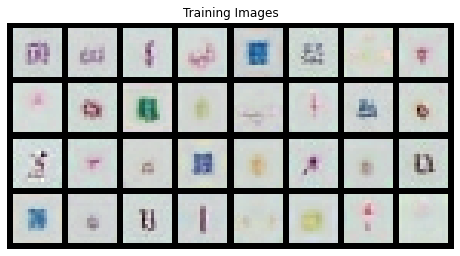

In [71]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(torch.from_numpy(img_list[299].numpy()), padding=2, normalize=True),(1,2,0)))